In [1]:
using JLD2
using PyPlot
using StatsBase # Statistics
using Distributions
using PyCall
using ScikitLearn # machine learning package
@sk_import gaussian_process : GaussianProcessRegressor
@sk_import gaussian_process.kernels : Matern

# config plot settings
PyPlot.matplotlib.style.use("ggplot")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

In [2]:
@load joinpath(pwd(), "targets_and_normalized_features.jld2") X henry_y gcmc_y henry_total_elapsed_time gcmc_elapsed_time

5-element Vector{Symbol}:
 :X
 :henry_y
 :gcmc_y
 :henry_total_elapsed_time
 :gcmc_elapsed_time

## BO Function

In [3]:
### procedure:
# 1. select initial COF identifiers set to train GP 
# 2. initialize and normalize array of initial target data 
# 3. itterate through budgetted number of BO runs
#    a. construct GP model with kernel
#    b. fit GP to current data for acquired COFs => gives ŷ(x)
#    c. construct acquiaition function A(x)
#    d. determine which COF to acquire next => evaluate argmax(A(x))
#       i. for EI track if this is an exploitation or an exploration
#    e. append COF identified in step 3.d to list of acquired COFs 
# 4. update final set of acquired COF data and normalize
# 5. return the IDs for the set of acquired COFs
###
"""
# Arguments
- `X`: feature matrix
- `y`: target vector
- `nb_iterations`: maximum number of BO iterations (experiment budget)
- `which_acquisition`: which acquisition function to implement
` `store_explore_exploit_terms`: whether or not to keep track of the explore and exploit 
                                 terms from the acqisition for the acquired material at each iteration
- `sample_gp`: whether or not to store sample GP functions
- `initialize_with`: specify which and/or how many materials to initialize the search
- `kwargs`: dictionary of optional keyword arguments
"""
function run_bayesian_optimization(X, y, nb_iterations::Int, 
                                   nb_COFs_initialization::Int;
                                   which_acquisition::Symbol=:UCB,
                                   store_explore_exploit_terms::Bool=false,
                                   sample_gp::Bool=false,
                                   initialize_with::Union{Array{Int, 1}, Nothing}=nothing,
                                   kwargs::Dict{Symbol, Any}=Dict{Symbol, Any}())
    # quick checks
    @assert nb_iterations > nb_COFs_initialization "More initializations than itterations not allowed."
    @assert which_acquisition in [:UCB, :EI] "Acquisition function not supported:\t $(which_acquisition)"
    
    # create array to store explore-explot terms if needed
    if store_explore_exploit_terms
        explore_exploit_balance = []
    end
    
    if sample_gp
        store_sample_y = []
    end
    
    normal = Normal()
    
    ###
    #  1. randomly select COF IDs for training initial GP
    ###
    if isnothing(initialize_with)
        ids_acquired = StatsBase.sample(1:nb_COFs, nb_COFs_initialization, replace=false)
        @assert length(unique(ids_acquired)) == nb_COFs_initialization
    else
        # initialize using a specified set of indecies
        ids_acquired = initialize_with
        @assert length(unique(ids_acquired)) == nb_COFs_initialization
    end
     
    ###
    #  3. itterate through budgetted number of BO runs
    ###
    for i in range(nb_COFs_initialization, stop=nb_iterations)
        ###
        #  a-b. construct and fit GP model
        ###
        kernel = Matern(nu=2.5, length_scale=0.25) 
        model = GaussianProcessRegressor(kernel=kernel, normalize_y=true, n_restarts_optimizer=5)
        model.fit(X[ids_acquired, :], y[ids_acquired]) #train model on acquired data
        
        if sample_gp
            sample_y = model.sample_y(X)
            push!(store_sample_y, sample_y)
        end
        
        ŷ, σ = model.predict(X, return_std=true)

        
        ###
        #  c. setup acquisition function
        ###
        if which_acquisition == :UCB
            # A(x) = ŷ(x) + βσ(x)
            # where β controlls exploitation-exploration trade-off
            β = 2.0
            acquisition_values = ŷ .+ β * σ
        elseif which_acquisition == :EI
            # A(x) = integral{-∞}{+∞}[I(x)N(y|ŷ(x), σ²(x))dy]
            # where I(x) = max(0, f(x) - maxᵢ(yᵢ))
            if any(σ .== 0.0)
                acquisition_values = zeros(length(σ))
            else
                y_max = maximum(y[ids_acquired])
                z = (ŷ .- y_max) ./ σ
                
                exploit_term = (ŷ .- y_max) .* cdf(normal, z) 
                explore_term = σ .* pdf(normal, z)
                
                acquisition_values = exploit_term .+ explore_term
            end
        end
        
        ###
        #  d. determine which COF to acquire next
        ###
        ids_sorted_by_aquisition = sortperm(acquisition_values, rev=true)
        for id_max_aquisition in ids_sorted_by_aquisition
            if ! (id_max_aquisition in ids_acquired)
                ###
                #  e. acqurie this COF (i.e. update list)
                ###
                push!(ids_acquired, id_max_aquisition)
                if store_explore_exploit_terms
                    # store explore and exploit terms
                    if which_acquisition == :UCB
                        push!(explore_exploit_balance, 
                              [ŷ[id_max_aquisition], β * σ[id_max_aquisition]])
                    elseif which_acquisition == :EI
                        push!(explore_exploit_balance, 
                              [exploit_term[id_max_aquisition], explore_term[id_max_aquisition]])
                    end
                end
                break
            end
        end
        # quick check
        @assert length(ids_acquired) == i + 1
    end
    
    # quick check (remember to account for final COF to be acquired)
    @assert length(ids_acquired) == nb_iterations + 1 "length(ids_acquired) = $(length(ids_acquired))"
    
    ###
    #  5. return the IDs for the set of acquired COFs
    ###
    if sample_gp
        return ids_acquired, explore_exploit_balance, store_sample_y
    else
        return ids_acquired, explore_exploit_balance
    end
end

run_bayesian_optimization

## Apply BO

In [4]:
###
#  Find COF located nearest the center of the feature space
###
min = sum(ones(Float64, length(X[1, :]))) # max possible value of normalized features
id_min = 0
com = 0.5 * ones(Float64, length(X[1, :])) # center of normalized feature space

for i in 1:length(X[:, 1])
    dist = sqrt(sum((X[i, :] .- com).^2))
    if dist < min
        min = dist
        id_min = i
    end
end
id_min, min

(26, 1.200853890165394)

In [5]:
nb_COFs = length(gcmc_y)
nb_iterations = 150
nb_COFs_initialization = 1
which_acquisition = :EI # :UCB or :EI 

# try to initialize using a COF that is close to the center of the domain (feature space)
initialize_with = [id_min]

1-element Vector{Int64}:
 26

In [6]:
acq_ids, eeb = run_bayesian_optimization(X, gcmc_y, nb_iterations, 
                                         nb_COFs_initialization;
                                         which_acquisition=which_acquisition,
                                         store_explore_exploit_terms=true,
                                         sample_gp=false,
                                         initialize_with=initialize_with);

acq_ids;

In [7]:
# sum(henry_total_elapsed_time[acq_ids[:]])
sum(gcmc_elapsed_time[acq_ids[:]])

45571.308481514454

## Plot: search efficiency curve

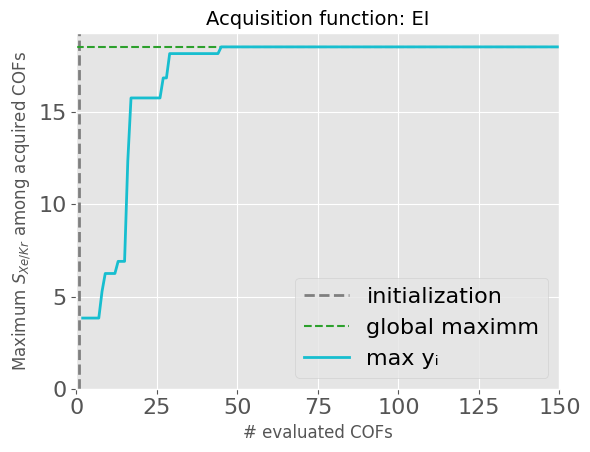

In [8]:
# plot maximum selectivity among acquired COFs as a function of the number of COFs acquired (itterations)
index = zeros(Int64, length(acq_ids))
max_selectivity = zeros(Float64, length(acq_ids))
for i in 1:length(acq_ids)
    ids = acq_ids[1:i]
    max_y = maximum(gcmc_y[ids])
    max_selectivity[i] = max_y
    ittration = i + nb_COFs_initialization
    index[i] = ittration
end

figure()

axvline(x=nb_COFs_initialization, label="initialization", color="tab:grey", linestyle="--", lw=2)
axhline(y=maximum(gcmc_y), label="global maximm", color="tab:green", ls="--", lw=1.5)

plot(index, max_selectivity, label="max yᵢ", color="tab:cyan", lw=2)

title("Acquisition function: $(string(which_acquisition))", fontsize=14)
legend(loc="lower right")
xlabel("# evaluated COFs", fontsize=12)
ylabel("Maximum " * L"S_{Xe/Kr}" * " among acquired COFs", fontsize=12)
xlim([0.0, nb_iterations])
ylim(ymin=0.0)

tight_layout()
# savefig(joinpath(pwd(), "figs", 
#         "search_efficientcy_curve_$(string(which_acquisition)).pdf"), dpi=600, format="pdf")

### Elxploration-Exploitation 

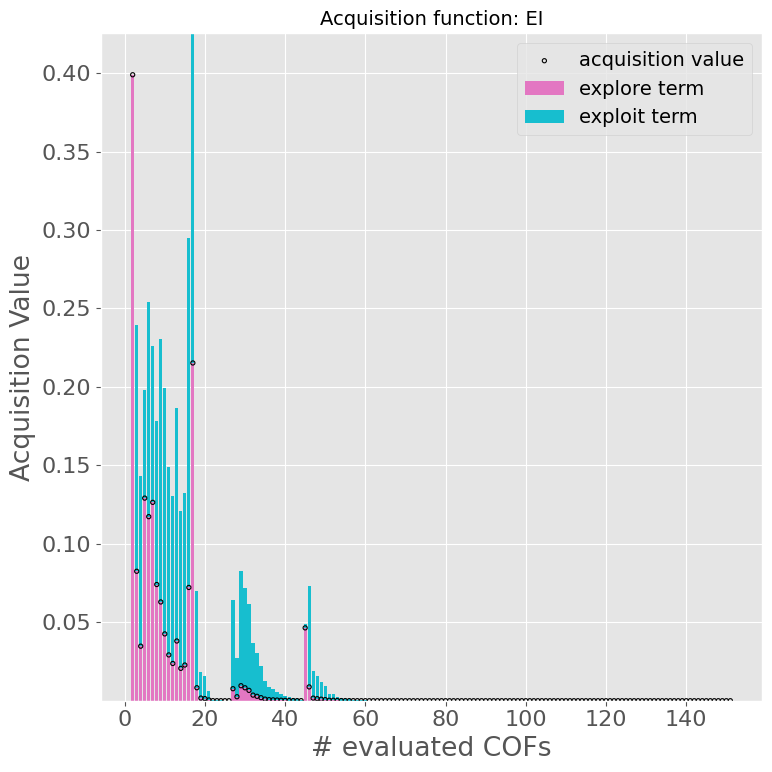

In [9]:
# make a plot of ŷ and σ as a function of itterations to see exploitation vs exploration
fig, axs = subplots(figsize=(8, 8))

index = [i + nb_COFs_initialization for i in nb_COFs_initialization:nb_iterations]
exploit = [eeb[i][1] for i in 1:length(eeb)]
explore = [eeb[i][2] for i in 1:length(eeb)]

axs.bar(index, explore, label="explore term", color="tab:pink")
axs.bar(index, exploit, label="exploit term", color="tab:cyan", 
        ls="--", bottom=explore)


axs.scatter(index, exploit .+ explore, label="acquisition value", 
            marker=".", facecolor="none", edgecolor="k", lw=0.8, zorder=2)

title("Acquisition function: $(string(which_acquisition))", fontsize=14)
axs.legend(fontsize=14)
axs.set_xlabel("# evaluated COFs")
axs.set_ylabel("Acquisition Value")
# axs.set_ylabel("expected improvement")

tight_layout()
# savefig(joinpath(pwd(), "figs", 
#         "exploration_exploitation_balance_$(string(which_acquisition)).png"), dpi=600, format="png")

In [10]:
# Which COF is predicted to be the best?

### Cost

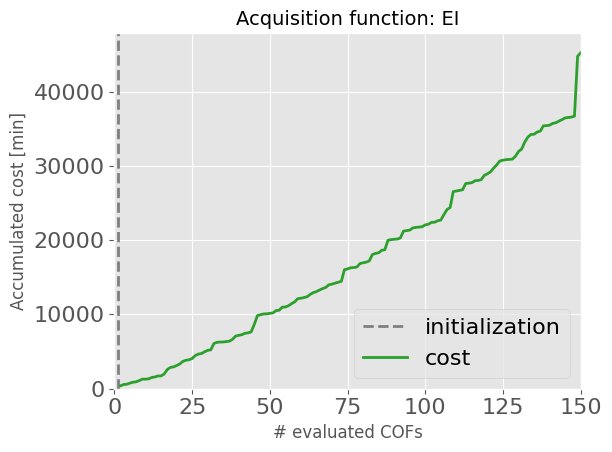

In [11]:
# plot accumulated cost as a function of the number of COFs acquired (itterations)
index = zeros(Int64, length(acq_ids))
acq_cost = zeros(Float64, length(acq_ids))
for i in 1:length(acq_ids)
    ids = acq_ids[1:i]
    acq_cost[i] = sum(gcmc_elapsed_time[ids])
    ittration = i + nb_COFs_initialization
    index[i] = ittration
end

figure()
axvline(x=nb_COFs_initialization, label="initialization", color="tab:grey", linestyle="--", lw=2)

plot(index, acq_cost, label="cost", color="tab:green", lw=2)

title("Acquisition function: $(string(which_acquisition))", fontsize=14)
legend(loc="lower right")
xlabel("# evaluated COFs", fontsize=12)
ylabel("Accumulated cost [min]", fontsize=12)
xlim([0.0, nb_iterations])
ylim(ymin=0.0)

tight_layout()
# savefig(joinpath(pwd(), "figs", 
#         "accumulated_cost_$(string(which_acquisition)).pdf"), dpi=600, format="pdf")